# What caused the dip in the weekly active users?

## Out line of the problem
- ### Find what caused the dip in the weekly active users (defined by number of users who logged at least one engagement event during the week)

- ### Maximize the return on their time.

- ### Evaluate based on core engagement, retention, and growth metric.


- ### some notes: number of user with at least one event may not be the right metric. (If we have lots of users doing very little every week, this number will go up. For example, everyone trying out a new product and then few core users using them will results in drop in this number). Also company makes money from the number of company using it. Not the number of users and definitely not with the number of users with at least one event per week. Thus we need to know what type of events were occuring and who were the users that dropped out. Also we want to know what caused the initial increase because that is the most significant event here. One possibility is a free promotion or similar event where lots of users were made at that point, who tried few things and then settled down to the users who use it and users who don't. Number of events per user?



## Approach
- ### Develop a two-tier classification system that can achieve high accuracy without using too much resourses.

- ### First step will focus on achieving high recall with few features. Subjects whose cells were classified as malignant will advance to step two.

- ### Second step will focus on increasing accuracy with all features.

## Summary
- ### First use a logistic regression model that uses only one feature "Bare Nuclei" to calculate the probability of the cells being malignant. Categorize all subjects with probability higher than 30% as "malignant" to increase recall.

- ### For subjects categorized as "malignant", use a logistic regression model that uses all the features to accurately cateogorize them.

## Relevant analyses

In [1]:
#Import necessary packages

import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Read in the original data file received. Remove the description and save as an excel file in the data directory. 

### while inspecting the data, noticed that:

- There are missing values.
- There are duplicate data.
- There are features whose values are larger than 10.

### Read in the data:

In [2]:
#Read the provided data (after deleting the data description line and saving it as .xlsx) to pandas dataframe
current_path = os.getcwd()
file = '/datasets/Yammer/dimension_rollup_periods.xlsx'
rollup_periods = pd.read_excel(current_path + file)

In [3]:
rollup_periods.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
0,1,2013-01-01,2013-01-01,2013-01-02,2013-01-01 08:00:00,2013-01-02 08:00:00
1,1,2013-01-02,2013-01-02,2013-01-03,2013-01-02 08:00:00,2013-01-03 08:00:00
2,1,2013-01-03,2013-01-03,2013-01-04,2013-01-03 08:00:00,2013-01-04 08:00:00
3,1,2013-01-04,2013-01-04,2013-01-05,2013-01-04 08:00:00,2013-01-05 08:00:00
4,1,2013-01-05,2013-01-05,2013-01-06,2013-01-05 08:00:00,2013-01-06 08:00:00


In [4]:
rollup_periods.describe()

,period_id
count,56002.000000
mean,1920.645227
std,347.572356
min,1.000000
25%,2001.000000
50%,2001.000000
75%,2007.000000
max,2007.000000


In [8]:
rollup_periods.iloc[0,0]

1

In [25]:
data_period=rollup_periods.loc[(rollup_periods['period_id'] == 1007)]

In [26]:
data_period.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
1252,1007,2013-01-01,2012-12-25,2013-01-01,2012-12-25 08:00:00,2013-01-01 08:00:00
1253,1007,2013-01-02,2012-12-26,2013-01-02,2012-12-26 08:00:00,2013-01-02 08:00:00
1254,1007,2013-01-03,2012-12-27,2013-01-03,2012-12-27 08:00:00,2013-01-03 08:00:00
1255,1007,2013-01-04,2012-12-28,2013-01-04,2012-12-28 08:00:00,2013-01-04 08:00:00
1256,1007,2013-01-05,2012-12-29,2013-01-05,2012-12-29 08:00:00,2013-01-05 08:00:00


In [27]:
mask = (data_period['pst_start'] > '2014-5-1') & (data_period['pst_start'] <= '2014-9-01')
#print(data_period.loc[mask])


In [28]:
 selected_period = data_period.loc[mask]

In [29]:
selected_period.head()

,period_id,time_id,pst_start,pst_end,utc_start,utc_end
1745,1007,2014-05-09,2014-05-02,2014-05-09,2014-05-02 07:00:00,2014-05-09 07:00:00
1746,1007,2014-05-10,2014-05-03,2014-05-10,2014-05-03 07:00:00,2014-05-10 07:00:00
1747,1007,2014-05-11,2014-05-04,2014-05-11,2014-05-04 07:00:00,2014-05-11 07:00:00
1748,1007,2014-05-12,2014-05-05,2014-05-12,2014-05-05 07:00:00,2014-05-12 07:00:00
1749,1007,2014-05-13,2014-05-06,2014-05-13,2014-05-06 07:00:00,2014-05-13 07:00:00


In [12]:
file = '/datasets/Yammer/yammer_events.xlsx'
events = pd.read_excel(current_path + file)

In [30]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [33]:
signup_events=events.loc[events['event_type']=='signup_flow']

In [34]:
signup_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
391,11768,2014-05-01 08:01:36,signup_flow,create_user,France,macbook pro,NaN
392,11768,2014-05-01 08:02:06,signup_flow,enter_email,France,macbook pro,NaN
393,11768,2014-05-01 08:02:39,signup_flow,enter_info,France,macbook pro,NaN
394,11768,2014-05-01 08:03:12,signup_flow,complete_signup,France,macbook pro,3.0
401,11769,2014-05-01 02:37:43,signup_flow,create_user,United Kingdom,lenovo thinkpad,NaN


In [35]:
signup_events.describe()

,user_id,user_type
count,19257.000000,3680.000000
mean,15431.248377,2.224185
std,2105.927922,0.810714
min,11768.000000,1.000000
25%,13612.000000,2.000000
50%,15430.000000,2.000000
75%,17260.000000,3.000000
max,19065.000000,3.000000


In [130]:
#Change the data type to float. Any non-numeric values will become NaN
original_data_numeric = pd.DataFrame().reindex_like(original_data)

#Run a for loop to change each column to float type
for index in range(original_data.shape[1]):
   
   # Select column by index position using iloc[]
    original_data_numeric.iloc[:,index] = (pd.to_numeric(original_data.iloc[:,index], errors='coerce'))


### Remove rows with missing values

In [132]:
#drop all rows that contain NaN for now.
data_without_nan = original_data_numeric.dropna()
#Use 'index' as row index.
data_without_nan = data_without_nan.set_index('index')

### Remove duplicate data

In [133]:
#remove duplicate rows (use the first one as unique)
data_without_nan.drop_duplicates(inplace = True) 

### Remove data that's out of range

In [134]:
#Some values are going above the 10. Chose rows that have values equal to or less than 10.

data_without_nan_filtered = data_without_nan[(data_without_nan['Clump Thickness'] <= 10) & (data_without_nan['Uniformity of Cell Size'] <= 10)] 



### Distribution of the features are skewed. Log transform them to bring it closer to normal distribution

In [137]:
features = data_without_nan_filtered.iloc[:,1:10]
transformed_features = features.apply(np.log)

### Standardize the features (subtract mean and divide by the standard deviation)

In [138]:
scaler_feature = pp.StandardScaler().fit(transformed_features)
transformed_features_normalized = scaler_feature.transform(transformed_features)
transformed_features_normalizedDF = pd.DataFrame(data=transformed_features_normalized)


### Build logistic regression model using all the features. Aim for high accuracy

In [144]:
cancer_state = data_without_nan_filtered.iloc[:,10]

X_train, X_test, y_train, y_test = train_test_split(transformed_features_normalizedDF, cancer_state, test_size = 0.2,stratify=cancer_state)

clf = LogisticRegressionCV(cv=5).fit(X_train, y_train)
predicted_label = clf.predict(X_test)
    
score = clf.score(X_test, y_test)
#accuracy score
print(score)  

0.9777777777777777


In [165]:
print(metrics.confusion_matrix(y_test, predicted_label))

[[86  2]
 [ 1 46]]


### Inspect the coefficients in this model to identify a feature with the highest predictive value. Identify that a feature "Bare Nuclei" has the highest coefficient.

In [145]:
clf.coef_

array([[0.90388066, 0.674033  , 0.8716097 , 0.31240304, 0.27714243,
        1.03896015, 0.72251143, 0.51586553, 0.49034507]])

### Test a logist regression model with just "Bare Nuclei" and see how accurate it is. 

In [150]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(transformed_features_normalizedDF.iloc[:,5:6], cancer_state, test_size = 0.2,stratify=cancer_state)

clf2 = LogisticRegressionCV(cv=5).fit(X_train2, y_train2)
predicted_label2 = clf2.predict(X_test2)
    
score2 = clf2.score(X_test2, y_test2)
print(score2)    

0.9259259259259259


### Accuracy of 92.5 % is close to the accuracy of the full model. Check the confusion matrix to see how many false negatives we have. 

In [151]:
print(metrics.confusion_matrix(y_test2, predicted_label2))

[[84  4]
 [ 6 41]]


### Check the predicted probability of the each test data and see if any of the 4 false negatives were close to becoming positive (default categorization probability of 0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b547fc1d0>]],
      dtype=object)

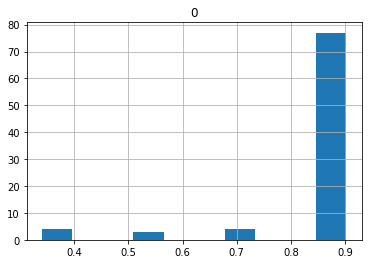

In [152]:
predicted_proba2 = clf2.predict_proba(X_test2)
predicted_proba2_df = pd.DataFrame(data=predicted_proba2[y_test2 == 2.0,0])
predicted_proba2_df.hist()

### Detailed inspection of the probability shows that decreasing the categorization threshold to 0.3 will reduce the false negative to zero in this particular test set, at the expense of increasing the falst postive by 10.

In [153]:
predicted_proba2[y_test2 == 2.0,0]

array([0.72739015, 0.90242259, 0.90242259, 0.90242259, 0.56323553,
       0.90242259, 0.56323553, 0.90242259, 0.90242259, 0.34034528,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.72739015, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.34034528, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.34034528, 0.90242259, 0.90242259, 0.72739015, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.34034528, 0.90242259,
       0.90242259, 0.90242259, 0.72739015, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242259,
       0.90242259, 0.90242259, 0.90242259, 0.90242259, 0.90242

In [154]:
predicted_proba2[y_test2 == 4.0,0]

array([0.12956938, 0.12956938, 0.34034528, 0.18173898, 0.12956938,
       0.72739015, 0.12956938, 0.12956938, 0.12956938, 0.12956938,
       0.12956938, 0.12956938, 0.12956938, 0.34034528, 0.22008878,
       0.34034528, 0.12956938, 0.56323553, 0.12956938, 0.12956938,
       0.34034528, 0.34034528, 0.12956938, 0.56323553, 0.34034528,
       0.34034528, 0.12956938, 0.34034528, 0.12956938, 0.12956938,
       0.12956938, 0.90242259, 0.90242259, 0.15240915, 0.15240915,
       0.90242259, 0.12956938, 0.22008878, 0.12956938, 0.12956938,
       0.27116659, 0.12956938, 0.12956938, 0.12956938, 0.43497184,
       0.18173898, 0.43497184])

### For subjects above the probability of 0.3, run a second round of classification using the second model. Now there is only one false positive and one false negative.

In [170]:
#Select the subjects that would go into the second round if we set the threshold at 0.3 probability
X_test3 = X_test2.loc[predicted_proba2[:,0]>0.3]
y_test3 = y_test2.loc[predicted_proba2[:,0]>0.3]

#Select the full features for those subjects.
X_test3_full = transformed_features_normalizedDF[transformed_features_normalizedDF.index.isin(X_test3.index)]

#sort the y_test3 values based on the index (because the X_test3_full will be sorted according to the index)
y_test3.sort_index(inplace=True)
#prediction for those subjects using the full model.
predicted_label3 = clf.predict(X_test3_full)
print(metrics.confusion_matrix(y_test3, predicted_label3))

[[87  1]
 [ 1 15]]


## Results

- ### By using two tier logistic regression model, doctors can reduce the cost of testing by measuring only one feature for the majority of subjects, while still maintaining high accuracy of the test.

- ### In the first step, the doctors will just use "Bare Nuclei" feature and use logistic regression with the threshold of 30% probability to identify potentially malignant cells.

- ### In the second step, the doctors will use all features to maximize the accuracy.

## Future directions

- ### Try to reduce the number of features in the full feature model to see if we can maintain the accuracy with less feature